In [1]:
import praw
from datetime import datetime, timedelta
from pymongo import MongoClient
import time

In [2]:
client = MongoClient('localhost', 27017)
db = client['482_Project']
collection = db['Reddit_Posts']
collection = db['Reddit_Posts_day']

In [3]:
reddit = praw.Reddit(
    client_id='',
    client_secret='',
    user_agent='Used to get data for 482',
)

In [4]:
def fetch_top_posts_month(subreddit_name, limit=20):
    subreddit = reddit.subreddit(subreddit_name)
    top_posts = []
    for submission in subreddit.top(time_filter ="month", limit=limit,):
        post_data = {
            'id': submission.id,
            'title': submission.title,
            'content': submission.selftext,
            'score': submission.score,
            'url': "https://www.reddit.com" + submission.permalink,
            'subreddit': submission.subreddit.display_name,
            'link_in_post': submission.url,
            'created_utc': datetime.fromtimestamp(submission.created_utc)
        }
        top_posts.append(post_data)
    return top_posts

In [4]:
def fetch_top_posts_day(subreddit_name, limit=20):
    subreddit = reddit.subreddit(subreddit_name)
    top_posts = []
    for submission in subreddit.top(time_filter ="day", limit=limit,):
        post_data = {
            'id': submission.id,
            'title': submission.title,
            'content': submission.selftext,
            'score': submission.score,
            'url': "https://www.reddit.com" + submission.permalink,
            'subreddit': submission.subreddit.display_name,
            'link_in_post': submission.url,
            'created_utc': datetime.fromtimestamp(submission.created_utc)
        }
        top_posts.append(post_data)
    return top_posts

In [5]:
subreddits = ["wallstreetbets", "Superstonk", "investing", "stocks"]

In [6]:
for subreddit in subreddits:
    collection.insert_many(fetch_top_posts_day(subreddit, limit=100))

In [7]:
print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))

2024-03-28 01:14:14


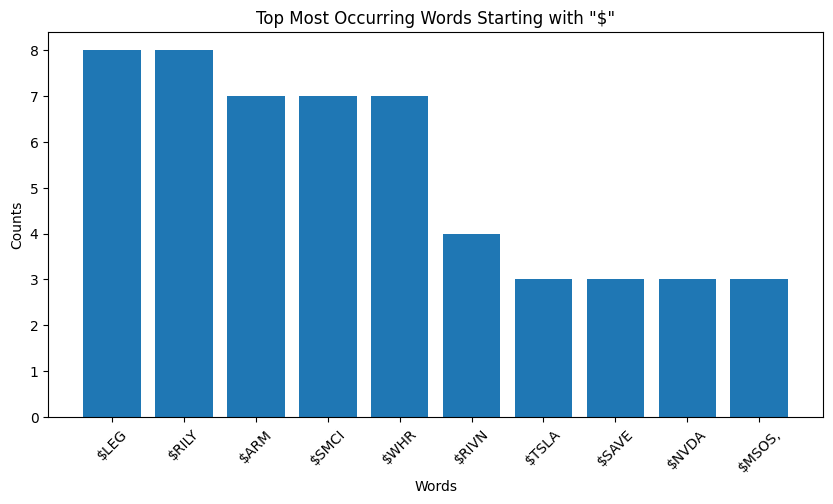

In [33]:
import matplotlib.pyplot as plt

# Query the database for titles and contents containing "$" at all
results = collection.find(
    {"$and": [
        {"title": {"$regex": ".*\$.*"}},
        {"content": {"$regex": ".*\$.*"}}
    ]}
)

# Create a list of words from titles and contents
words = []
for result in results:
    words.extend(result['title'].split())
    words.extend(result['content'].split())

# Count the occurrence of each word
word_counts = {}
for word in words:
    if word.startswith('$') and len(word) > 1 and not (word[1].isnumeric()):
        word_counts[word] = word_counts.get(word, 0) + 1

# Sort the word counts in descending order
sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

# Get the top most occurring words and their counts
top_words = [word for word, count in sorted_word_counts[:10]]
top_counts = [count for word, count in sorted_word_counts[:10]]


# Plot the bar chart
plt.figure(figsize=(10, 5))
plt.bar(top_words, top_counts)
plt.xlabel('Words')
plt.ylabel('Counts')
plt.title('Top Most Occurring Words Starting with "$"')
plt.xticks(rotation=45)
plt.show()
